In [ ]:
import os
import json
import math
import numpy as np
from typing import Any, Sequence
import pickle
from copy import deepcopy

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set()

from tqdm.auto import tqdm

import jax
import jax.numpy as jnp
import jax.random as random

import flax
from flax import linen as nn
from flax.training import train_state, orbax_utils

import optax

import orbax

In [ ]:
DATASET_PATH = "/data"
CHECKPOINT_PATH = "/tutorial_2"

print(f"{jax.devices()=}")

jax.devices()=[CpuDevice(id=0)]


In [ ]:
import urllib.request
from urllib.error import HTTPError


base_url = "https://raw.githubusercontent.com/phlippe/saved_models/main/JAX/tutorial3/"

# pretrained_files = ["FashionMNIST_elu.config", "FashionMNIST_elu.tar",
#                     "FashionMNIST_leakyrelu.config", "FashionMNIST_leakyrelu.tar",
#                     "FashionMNIST_relu.config", "FashionMNIST_relu.tar",
#                     "FashionMNIST_sigmoid.config", "FashionMNIST_sigmoid.tar",
#                     "FashionMNIST_swish.config", "FashionMNIST_swish.tar",
#                     "FashionMNIST_tanh.config", "FashionMNIST_tanh.tar"]

pretrained_files = ["FashionMNIST_elu.config",
                    "FashionMNIST_leakyrelu.config",
                    "FashionMNIST_relu.config",
                    "FashionMNIST_sigmoid.config",
                    "FashionMNIST_swish.config",
                    "FashionMNIST_tanh.config",]

os.makedirs(CHECKPOINT_PATH, exist_ok=True)

for file_name in pretrained_files:
    file_path = os.path.join(CHECKPOINT_PATH, file_name)
    if not os.path.isfile(file_path):
        file_url = base_url + file_name
        print(f"Downloading {file_url}...")
        try:
            urllib.request.urlretrieve(file_url, file_path)
        except HTTPError as e:
            print("Something went wrong. Please contact the author with the full output including the following error:\n", e)

In [ ]:
class Sigmoid(nn.Module):
    def __call__(self, x):
        return 1/ (1 + jnp.exp(-x))

class Tanh(nn.Module):
    def __call__(self, x):
        x_exp, neg_x_exp = jnp.exp(x), jnp.exp(-x)
        return (x_exp - neg_x_exp) / (x_exp + neg_x_exp)

In [ ]:
class ReLU(nn.Module):
    def __call__(self, x):
        return jnp.maximum(x, 0)

class LeakyReLU(nn.Module):
    alpha: float = 0.1

    def __call__(self, x):
        return jnp.where(x>0, x, self.alpha*x)

class ELU(nn.Module):
    def __call__(self, x):
        return jnp.where(x>0, x, jnp.exp(x)-1)

class Swish(nn.Module):
    def __call__(self, x):
        return x * nn.sigmoid(x)

In [ ]:
act_fn_by_name = {
    "sigmoid": Sigmoid,
    "tanh": Tanh,
    "relu": ReLU,
    "leakyrelu": LeakyReLU,
    "elu": ELU,
    "swish": Swish
}

### Visualizing activation functions

In [ ]:
def get_grads(act_fn, x):
    return jax.vmap(
        jax.grad(act_fn)
    )(x)

In [ ]:
def vis_act_fn(act_fn, ax, x):
    y = act_fn(x)
    y_grads = get_grads(act_fn, x)

    ax.plot(x, y, linewidth=2, label='ActFn')
    ax.plot(x, y_grads, linewidth=2, label='Gradient')
    ax.set_title(act_fn.__class__.__name__)
    ax.legend()
    ax.set_ylim(-1.5, x.max())


act_fns = [act_fn() for act_fn in act_fn_by_name.values()]
x = np.linspace(-5, 5, 1000)

rows = math.ceil(len(act_fns) / 2.0)
fig, ax = plt.subplots(rows, 2, figsize=(8, rows*4))
for i, act_fn in enumerate(act_fns):
    vis_act_fn(act_fn, ax[divmod(i,2)], x)

fig.subplots_adjust(hspace=0.3)
plt.show()

## Effect of activation functions

In [ ]:
init_func = lambda x : (
    lambda rng, shape, dtype: random.uniform(
        rng,
        shape=shape,
        minval=-1/np.sqrt(x.shape[1]),
        maxval=1/np.sqrt(x.shape[1]),
        dtype=dtype
    )
)

In [ ]:
class BaseNetwork(nn.Module):
    act_fn: nn.Module
    num_classes: int = 10
    hidden_sizes: Sequence = (512, 256, 256, 128)

    @nn.compact
    def __call__(self, x, return_activations=False):
        x = x.reshape(x.shape[0], -1)

        activations = []
        for hd in self.hidden_sizes:
            x = nn.Dense(hd,
                         kernel_init=init_func(x),
                         bias_init=init_func(x))(x)
            activations.append(x)
            x = self.act_fn(x)
            activations.append(x)
        x = nn.Dense(self.num_classes,
                     kernel_init=init_func(x),
                     bias_init=init_func(x))(x)
        return x if not return_activations else (x, activations)

In [ ]:
def _get_config_file(model_path, model_name):
    return os.path.join(model_path, model_name + ".config")

def _get_model_file(model_path, model_name):
    return os.path.join(model_path, model_name + ".tar")

def load_model(model_path, model_name, state=None):
    config_file = _get_config_file(model_path, model_name)
    model_file = _get_model_file(model_path, model_name)
    assert os.path.isfile(config_file)
    assert os.path.isfile(model_file)
    with open(config_file, "r") as f:
        config_dict = json.load(f)
    if state is None:
        act_fn_name = config_dict["act_fn"].pop("name").lower()
        act_fn = act_fn_by_name[act_fn_name](**config_dict.pop("act_fn"))
        net = BaseNetwork(act_fn=act_fn, **config_dict)
        state = train_state.TrainState(
            step=0,
            params=None,
            apply_fn=net.apply,
            tx=None,
            opt_state=None
        )
    else:
        net = None

    with open(model_file, 'rb') as f:
        params = pickle.load(f)
    state = state.replace(params=params)
    return state, net

def save_model(model, params, model_path, model_name):
    config_dict = {
        'num_classes': model.num_classes,
        'hidden_sizes': model.hidden_sizes,
        'act_fn': {
            'name': model.act_fn.__class__.__name__.lower()
        }
    }
    if hasattr(model.act_fn, 'alpha'):
        config_dict['act_fn']['alpha'] = model.act_fn.alpha
    os.makedirs(model_path, exist_ok=True)

    config_file, model_file = _get_config_file(model_path, model_name), _get_model_file(model_path, model_name)
    with open(config_file, "w") as f:
        json.dump(config_dict, f)
    # You can also use flax's checkpoint package. To show an alternative,
    # you can instead save the parameters simply in a pickle file.
    with open(model_file, 'wb') as f:
        pickle.dump(params, f)


In [ ]:
import torch
import torch.utils.data as data
import torchvision
from torchvision.datasets import FashionMNIST
from torchvision import transforms

In [ ]:
def image_to_numpy(img):
    img = np.array(img, dtype=np.float32)
    img = (img / 255.0 - 0.5) / 0.5
    return img


def numpy_collate(batch):
    if isinstance(batch[0], np.ndarray):
        return np.stack(batch)
    elif isinstance(batch[0], (tuple,list)):
        transposed = zip(*batch)
        return [numpy_collate(samples) for samples in transposed]
    else:
        return np.array(batch)

train_dataset = FashionMNIST(
    root=DATASET_PATH,
    train=True,
    transform=image_to_numpy,
    download=True
)

train_set, val_set = data.random_split(train_dataset,
                                       [50_000, 10_000],
                                       generator=torch.Generator().manual_seed(42))

test_set = FashionMNIST(root=DATASET_PATH,
                        train=False,
                        transform=image_to_numpy,
                        download=True)

train_loader = data.DataLoader(train_set,
                               batch_size=1024,
                               shuffle=False,
                               drop_last=False,
                               collate_fn=numpy_collate)

val_loader = data.DataLoader(val_set,
                             batch_size=1024,
                             shuffle=False,
                             drop_last=False,
                             collate_fn=numpy_collate)

test_loader = data.DataLoader(test_set,
                              batch_size=1024,
                              shuffle=False,
                              drop_last=False,
                              collate_fn=numpy_collate)

100%|██████████| 26.4M/26.4M [00:01<00:00, 15.4MB/s]
100%|██████████| 29.5k/29.5k [00:00<00:00, 225kB/s]
100%|██████████| 4.42M/4.42M [00:01<00:00, 3.75MB/s]
100%|██████████| 5.15k/5.15k [00:00<00:00, 10.7MB/s]


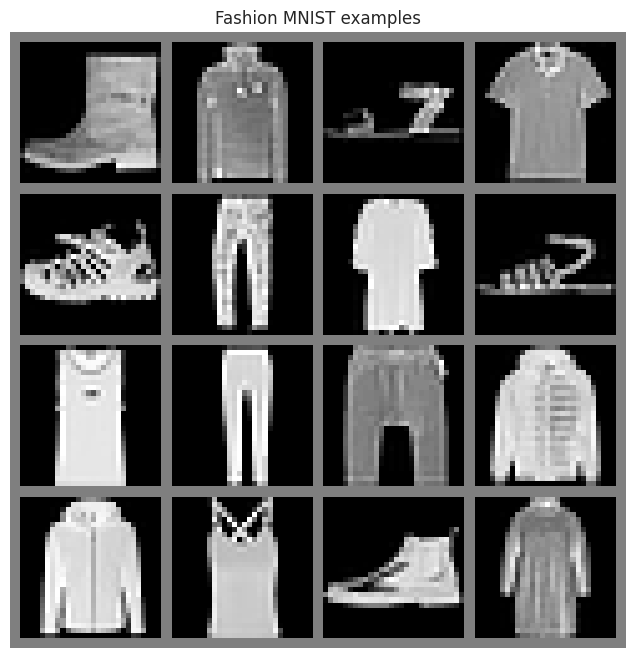

In [ ]:
exmp_images = [train_set[i][0] for i in range(16)]

img_grid = torchvision.utils.make_grid(torch.from_numpy(np.stack(exmp_images, axis=0))[:, None],
                                       nrow=4,
                                       normalize=True,
                                       pad_value=0.5)

img_grid = img_grid.permute(1, 2, 0)

plt.figure(figsize=(8,8))
plt.title('Fashion MNIST examples')
plt.imshow(img_grid)
plt.axis('off')
plt.show()
plt.close()

In [ ]:
small_loader = data.DataLoader(train_set, batch_size=256, shuffle=False, collate_fn=numpy_collate)
exmp_batch = next(iter(small_loader))

In [ ]:
def visualize_gradients(net, params, exmp_batch, color="C0"):
    def loss_func(p):
        img, labels = exmp_batch
        logits = net.apply(p, img)
        loss = optax.softmax_cross_entropy_with_integer_labels(logits, labels).mean()
        return loss

    grads = jax.grad(loss_func)(params)
    grads = jax.device_get(grads)

    grads = jax.tree_util.tree_leaves(grads)
    grads = [g.reshape(-1) for g in grads if len(g.shape) > 1]

    columns = len(grads)
    fig, ax = plt.subplots(1, columns, figsize=(columns*3.5, 2.5))
    fig_index = 0
    for g_idx, g in enumerate(grads):
        key = f'Layer {g_idx * 2} - weights'
        key_ax = ax[g_idx % columns]
        sns.histplot(data=g, bins=30, ax=key_ax, color=color, kde=True)
        key_ax.set_title(key)
        key_ax.set_xlabel('Grad Magnitude')
    fig.suptitle(f"Gradient magnitude distribution for activation function {net.act_fn.__class__.__name__}", fontsize=14, y=1.05)
    fig.subplots_adjust(wspace=0.45)
    plt.show()
    plt.close()

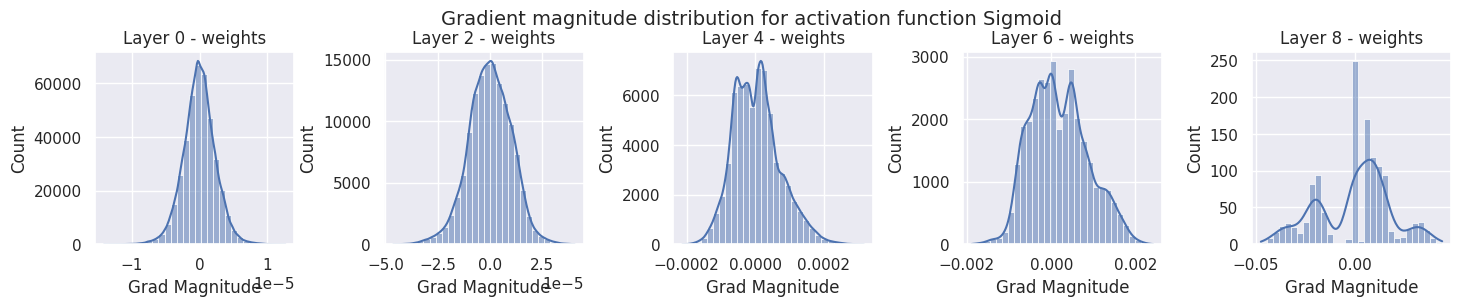

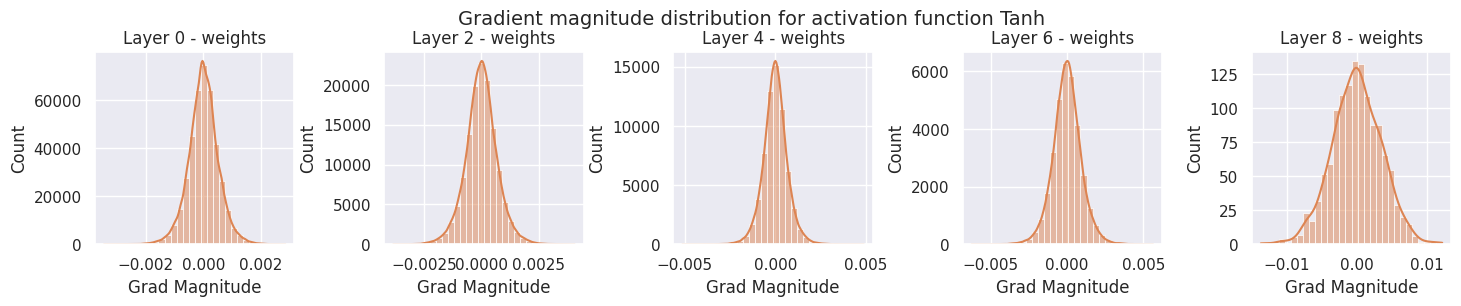

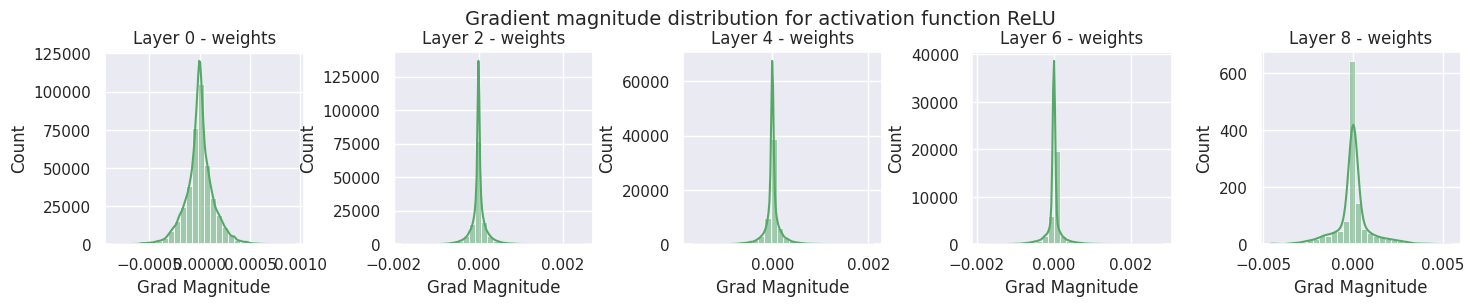

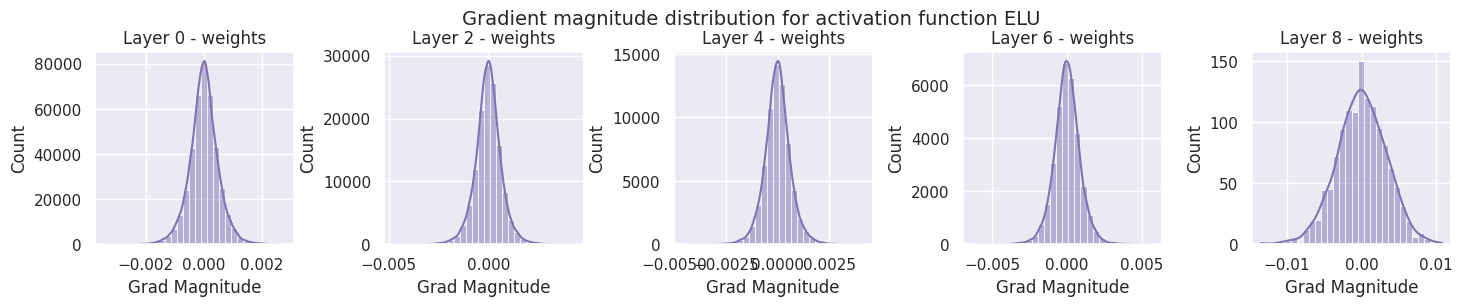

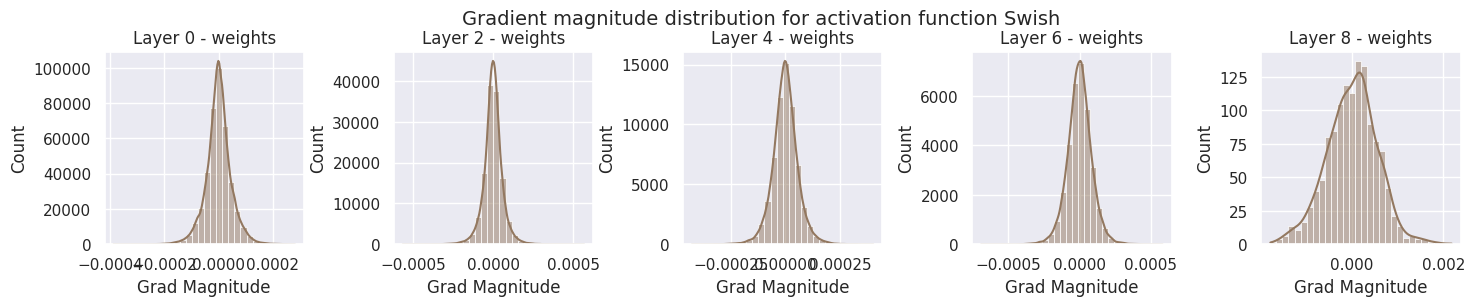

In [ ]:
import warnings

warnings.filterwarnings('ignore')

for i, act_fn_name in enumerate(act_fn_by_name):
    act_fn = act_fn_by_name[act_fn_name]()
    net_actfn = BaseNetwork(act_fn=act_fn)
    params = net_actfn.init(random.key(0), exmp_batch[0])
    visualize_gradients(net_actfn, params, exmp_batch, color=f'C{i}')

In [ ]:
def calculate_loss(params, apply_fn, batch):
    imgs, labels = batch
    logits = apply_fn(params, imgs)
    loss = optax.softmax_cross_entropy_with_integer_labels(logits, labels).mean()
    acc = (labels == logits.argmax(axis=-1)).mean()
    return loss, acc

@jax.jit
def train_step(state, batch):
    grad_fn = jax.value_and_grad(calculate_loss,
                                 has_aux=True)
    (_, acc), grads = grad_fn(state.params, state.apply_fn, batch)
    state = state.apply_gradients(grads=grads)
    return state, acc

@jax.jit
def eval_step(state, batch):
    _, acc = calculate_loss(state.params, state.apply_fn, batch)
    return acc

In [ ]:
def train_model(net, model_name, max_epochs=50, patience=7, batch_size=256, overwrite=False):
    file_exists = os.path.isfile(_get_model_file(CHECKPOINT_PATH, model_name))
    if file_exists and not overwrite:
        print("Model file already exists. Skipping training")
        state = None
    else:
        if file_exists:
            print(f'Model file exists, but will be overwritten..')

        params = net.init(random.key(42), exmp_batch[0])
        state = train_state.TrainState.create(apply_fn=net.apply,
                                       params=params,
                                       tx=optax.sgd(learning_rate=1e-2,
                                                    momentum=0.9))
        train_loader_local = data.DataLoader(train_set,
                                             batch_size=batch_size,
                                             shuffle=True,
                                             drop_last=True,
                                             collate_fn=numpy_collate,
                                             generator=torch.Generator().manual_seed(42))
        val_scores = []
        best_val_epoch = -1
        for epoch in range(max_epochs):
            train_acc = 0.0
            for batch in tqdm(train_loader_local, desc=f"Epoch {epoch+1}", leave=False):
                state, acc = train_step(state, batch)
                train_acc += acc
            train_acc /= len(train_loader_local)

            val_acc = test_model(state, val_loader)
            val_scores.append(val_acc)
            print(f"[Epoch {epoch+1:2d}] Training accuracy: {train_acc:05.2%}, Validation accuracy: {val_acc:4.2%}")

            if len(val_scores) == 1 or val_acc > val_scores[best_val_epoch]:
                print("\t (new best performance, saving model..)")
                save_model(net, state.params, CHECKPOINT_PATH, model_name)
                best_val_epoch = epoch
            elif best_val_epoch <= epoch - patience:
                print(f"Early stopping due to no improvement over the last {patience} epochs")
                break

        plt.plot([i for i in range(1, len(val_scores) + 1)], val_scores)
        plt.xlabel('Epochs')
        plt.ylabel("Validation accuracy")
        plt.title(f"Validation performance of {model_name}")
        plt.show()
        plt.close()

    state, _ = load_model(CHECKPOINT_PATH, model_name, state=state)
    test_acc = test_model(state, test_loader)
    print(f"Test accuracy: {test_acc:4.2%}".center(50, "=") + "\n")
    return state, test_acc

def test_model(state, data_loader):
    true_preds, count = 0., 0
    for batch in data_loader:
        acc = eval_step(state, batch)
        batch_size = batch[0].shape[0]
        true_preds += acc * batch_size
        count += batch_size

    test_acc = true_preds / count
    return test_acc

Training BaseNetwork with sigmoid activation...


Epoch 1:   0%|          | 0/195 [00:00<?, ?it/s]

[Epoch  1] Training accuracy: 9.88%, Validation accuracy: 9.74%
	 (new best performance, saving model..)


Epoch 2:   0%|          | 0/195 [00:00<?, ?it/s]

[Epoch  2] Training accuracy: 10.08%, Validation accuracy: 9.52%


Epoch 3:   0%|          | 0/195 [00:00<?, ?it/s]

[Epoch  3] Training accuracy: 10.06%, Validation accuracy: 9.85%
	 (new best performance, saving model..)


Epoch 4:   0%|          | 0/195 [00:00<?, ?it/s]

[Epoch  4] Training accuracy: 9.83%, Validation accuracy: 9.99%
	 (new best performance, saving model..)


Epoch 5:   0%|          | 0/195 [00:00<?, ?it/s]

[Epoch  5] Training accuracy: 10.16%, Validation accuracy: 9.74%


Epoch 6:   0%|          | 0/195 [00:00<?, ?it/s]

[Epoch  6] Training accuracy: 10.31%, Validation accuracy: 9.99%


Epoch 7:   0%|          | 0/195 [00:00<?, ?it/s]

[Epoch  7] Training accuracy: 10.25%, Validation accuracy: 10.74%
	 (new best performance, saving model..)


Epoch 8:   0%|          | 0/195 [00:00<?, ?it/s]

[Epoch  8] Training accuracy: 10.22%, Validation accuracy: 9.52%


Epoch 9:   0%|          | 0/195 [00:00<?, ?it/s]

[Epoch  9] Training accuracy: 10.23%, Validation accuracy: 10.74%


Epoch 10:   0%|          | 0/195 [00:00<?, ?it/s]

[Epoch 10] Training accuracy: 10.37%, Validation accuracy: 10.27%


Epoch 11:   0%|          | 0/195 [00:00<?, ?it/s]

[Epoch 11] Training accuracy: 10.41%, Validation accuracy: 10.27%


Epoch 12:   0%|          | 0/195 [00:00<?, ?it/s]

[Epoch 12] Training accuracy: 10.91%, Validation accuracy: 18.60%
	 (new best performance, saving model..)


Epoch 13:   0%|          | 0/195 [00:00<?, ?it/s]

[Epoch 13] Training accuracy: 11.12%, Validation accuracy: 19.23%
	 (new best performance, saving model..)


Epoch 14:   0%|          | 0/195 [00:00<?, ?it/s]

[Epoch 14] Training accuracy: 11.76%, Validation accuracy: 9.85%


Epoch 15:   0%|          | 0/195 [00:00<?, ?it/s]

[Epoch 15] Training accuracy: 16.29%, Validation accuracy: 21.04%
	 (new best performance, saving model..)


Epoch 16:   0%|          | 0/195 [00:00<?, ?it/s]

[Epoch 16] Training accuracy: 20.81%, Validation accuracy: 25.46%
	 (new best performance, saving model..)


Epoch 17:   0%|          | 0/195 [00:00<?, ?it/s]

[Epoch 17] Training accuracy: 26.12%, Validation accuracy: 32.02%
	 (new best performance, saving model..)


Epoch 18:   0%|          | 0/195 [00:00<?, ?it/s]

[Epoch 18] Training accuracy: 30.38%, Validation accuracy: 33.49%
	 (new best performance, saving model..)


Epoch 19:   0%|          | 0/195 [00:00<?, ?it/s]

[Epoch 19] Training accuracy: 35.32%, Validation accuracy: 41.05%
	 (new best performance, saving model..)


Epoch 20:   0%|          | 0/195 [00:00<?, ?it/s]

[Epoch 20] Training accuracy: 41.78%, Validation accuracy: 44.88%
	 (new best performance, saving model..)


Epoch 21:   0%|          | 0/195 [00:00<?, ?it/s]

[Epoch 21] Training accuracy: 46.95%, Validation accuracy: 50.08%
	 (new best performance, saving model..)


Epoch 22:   0%|          | 0/195 [00:00<?, ?it/s]

[Epoch 22] Training accuracy: 51.62%, Validation accuracy: 53.13%
	 (new best performance, saving model..)


Epoch 23:   0%|          | 0/195 [00:00<?, ?it/s]

[Epoch 23] Training accuracy: 53.97%, Validation accuracy: 54.75%
	 (new best performance, saving model..)


Epoch 24:   0%|          | 0/195 [00:00<?, ?it/s]

[Epoch 24] Training accuracy: 55.10%, Validation accuracy: 55.86%
	 (new best performance, saving model..)


Epoch 25:   0%|          | 0/195 [00:00<?, ?it/s]

[Epoch 25] Training accuracy: 56.14%, Validation accuracy: 55.63%


Epoch 26:   0%|          | 0/195 [00:00<?, ?it/s]

[Epoch 26] Training accuracy: 57.40%, Validation accuracy: 59.05%
	 (new best performance, saving model..)


Epoch 27:   0%|          | 0/195 [00:00<?, ?it/s]

[Epoch 27] Training accuracy: 58.71%, Validation accuracy: 57.62%


Epoch 28:   0%|          | 0/195 [00:00<?, ?it/s]

[Epoch 28] Training accuracy: 59.98%, Validation accuracy: 59.15%
	 (new best performance, saving model..)


Epoch 29:   0%|          | 0/195 [00:00<?, ?it/s]

[Epoch 29] Training accuracy: 61.17%, Validation accuracy: 59.99%
	 (new best performance, saving model..)


Epoch 30:   0%|          | 0/195 [00:00<?, ?it/s]

[Epoch 30] Training accuracy: 62.52%, Validation accuracy: 65.85%
	 (new best performance, saving model..)


Epoch 31:   0%|          | 0/195 [00:00<?, ?it/s]

[Epoch 31] Training accuracy: 63.86%, Validation accuracy: 65.32%


Epoch 32:   0%|          | 0/195 [00:00<?, ?it/s]

[Epoch 32] Training accuracy: 65.25%, Validation accuracy: 65.54%


Epoch 33:   0%|          | 0/195 [00:00<?, ?it/s]

[Epoch 33] Training accuracy: 66.01%, Validation accuracy: 65.99%
	 (new best performance, saving model..)


Epoch 34:   0%|          | 0/195 [00:00<?, ?it/s]

[Epoch 34] Training accuracy: 67.28%, Validation accuracy: 67.53%
	 (new best performance, saving model..)


Epoch 35:   0%|          | 0/195 [00:00<?, ?it/s]

[Epoch 35] Training accuracy: 68.19%, Validation accuracy: 67.42%


Epoch 36:   0%|          | 0/195 [00:00<?, ?it/s]

[Epoch 36] Training accuracy: 69.23%, Validation accuracy: 71.30%
	 (new best performance, saving model..)


Epoch 37:   0%|          | 0/195 [00:00<?, ?it/s]

[Epoch 37] Training accuracy: 70.23%, Validation accuracy: 71.49%
	 (new best performance, saving model..)


Epoch 38:   0%|          | 0/195 [00:00<?, ?it/s]

[Epoch 38] Training accuracy: 70.78%, Validation accuracy: 72.65%
	 (new best performance, saving model..)


Epoch 39:   0%|          | 0/195 [00:00<?, ?it/s]

[Epoch 39] Training accuracy: 71.67%, Validation accuracy: 71.34%


Epoch 40:   0%|          | 0/195 [00:00<?, ?it/s]

[Epoch 40] Training accuracy: 72.74%, Validation accuracy: 73.70%
	 (new best performance, saving model..)


Epoch 41:   0%|          | 0/195 [00:00<?, ?it/s]

[Epoch 41] Training accuracy: 73.29%, Validation accuracy: 74.19%
	 (new best performance, saving model..)


Epoch 42:   0%|          | 0/195 [00:00<?, ?it/s]

[Epoch 42] Training accuracy: 73.81%, Validation accuracy: 74.38%
	 (new best performance, saving model..)


Epoch 43:   0%|          | 0/195 [00:00<?, ?it/s]

[Epoch 43] Training accuracy: 74.91%, Validation accuracy: 75.15%
	 (new best performance, saving model..)


Epoch 44:   0%|          | 0/195 [00:00<?, ?it/s]

[Epoch 44] Training accuracy: 75.26%, Validation accuracy: 75.26%
	 (new best performance, saving model..)


Epoch 45:   0%|          | 0/195 [00:00<?, ?it/s]

[Epoch 45] Training accuracy: 75.70%, Validation accuracy: 74.68%


Epoch 46:   0%|          | 0/195 [00:00<?, ?it/s]

[Epoch 46] Training accuracy: 76.47%, Validation accuracy: 76.27%
	 (new best performance, saving model..)


Epoch 47:   0%|          | 0/195 [00:00<?, ?it/s]

[Epoch 47] Training accuracy: 77.02%, Validation accuracy: 76.36%
	 (new best performance, saving model..)


Epoch 48:   0%|          | 0/195 [00:00<?, ?it/s]

[Epoch 48] Training accuracy: 77.61%, Validation accuracy: 76.48%
	 (new best performance, saving model..)


Epoch 49:   0%|          | 0/195 [00:00<?, ?it/s]

[Epoch 49] Training accuracy: 78.08%, Validation accuracy: 77.46%
	 (new best performance, saving model..)


Epoch 50:   0%|          | 0/195 [00:00<?, ?it/s]

[Epoch 50] Training accuracy: 78.78%, Validation accuracy: 78.04%
	 (new best performance, saving model..)


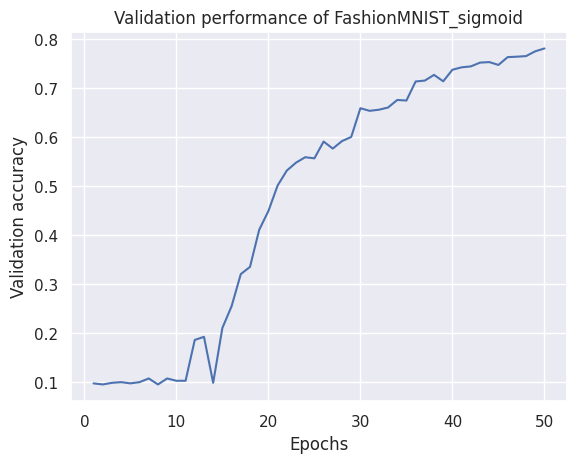

==============Test accuracy: 78.49%===============

Training BaseNetwork with tanh activation...


Epoch 1:   0%|          | 0/195 [00:00<?, ?it/s]

[Epoch  1] Training accuracy: 65.43%, Validation accuracy: 78.04%
	 (new best performance, saving model..)


Epoch 2:   0%|          | 0/195 [00:00<?, ?it/s]

[Epoch  2] Training accuracy: 81.65%, Validation accuracy: 82.78%
	 (new best performance, saving model..)


Epoch 3:   0%|          | 0/195 [00:00<?, ?it/s]

[Epoch  3] Training accuracy: 84.27%, Validation accuracy: 84.19%
	 (new best performance, saving model..)


Epoch 4:   0%|          | 0/195 [00:00<?, ?it/s]

[Epoch  4] Training accuracy: 85.21%, Validation accuracy: 84.71%
	 (new best performance, saving model..)


Epoch 5:   0%|          | 0/195 [00:00<?, ?it/s]

[Epoch  5] Training accuracy: 85.99%, Validation accuracy: 85.69%
	 (new best performance, saving model..)


Epoch 6:   0%|          | 0/195 [00:00<?, ?it/s]

[Epoch  6] Training accuracy: 86.48%, Validation accuracy: 86.09%
	 (new best performance, saving model..)


Epoch 7:   0%|          | 0/195 [00:00<?, ?it/s]

[Epoch  7] Training accuracy: 86.94%, Validation accuracy: 86.27%
	 (new best performance, saving model..)


Epoch 8:   0%|          | 0/195 [00:00<?, ?it/s]

[Epoch  8] Training accuracy: 87.25%, Validation accuracy: 86.53%
	 (new best performance, saving model..)


Epoch 9:   0%|          | 0/195 [00:00<?, ?it/s]

[Epoch  9] Training accuracy: 87.76%, Validation accuracy: 86.75%
	 (new best performance, saving model..)


Epoch 10:   0%|          | 0/195 [00:00<?, ?it/s]

[Epoch 10] Training accuracy: 87.97%, Validation accuracy: 86.29%


Epoch 11:   0%|          | 0/195 [00:00<?, ?it/s]

[Epoch 11] Training accuracy: 88.45%, Validation accuracy: 87.77%
	 (new best performance, saving model..)


Epoch 12:   0%|          | 0/195 [00:00<?, ?it/s]

[Epoch 12] Training accuracy: 88.67%, Validation accuracy: 87.43%


Epoch 13:   0%|          | 0/195 [00:00<?, ?it/s]

[Epoch 13] Training accuracy: 88.76%, Validation accuracy: 87.26%


Epoch 14:   0%|          | 0/195 [00:00<?, ?it/s]

[Epoch 14] Training accuracy: 89.29%, Validation accuracy: 88.31%
	 (new best performance, saving model..)


Epoch 15:   0%|          | 0/195 [00:00<?, ?it/s]

[Epoch 15] Training accuracy: 89.56%, Validation accuracy: 87.58%


Epoch 16:   0%|          | 0/195 [00:00<?, ?it/s]

[Epoch 16] Training accuracy: 89.44%, Validation accuracy: 87.22%


Epoch 17:   0%|          | 0/195 [00:00<?, ?it/s]

[Epoch 17] Training accuracy: 89.85%, Validation accuracy: 87.90%


Epoch 18:   0%|          | 0/195 [00:00<?, ?it/s]

[Epoch 18] Training accuracy: 89.98%, Validation accuracy: 88.31%


Epoch 19:   0%|          | 0/195 [00:00<?, ?it/s]

[Epoch 19] Training accuracy: 90.41%, Validation accuracy: 88.15%


Epoch 20:   0%|          | 0/195 [00:00<?, ?it/s]

[Epoch 20] Training accuracy: 90.44%, Validation accuracy: 87.77%


Epoch 21:   0%|          | 0/195 [00:00<?, ?it/s]

[Epoch 21] Training accuracy: 90.62%, Validation accuracy: 88.20%
Early stopping due to no improvement over the last 7 epochs


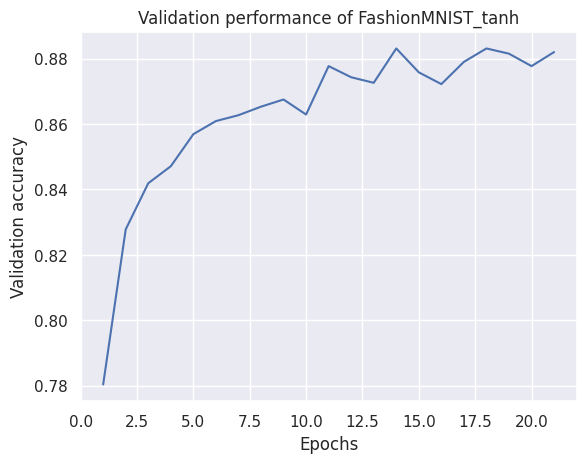

==============Test accuracy: 87.21%===============

Training BaseNetwork with relu activation...


Epoch 1:   0%|          | 0/195 [00:00<?, ?it/s]

[Epoch  1] Training accuracy: 50.28%, Validation accuracy: 71.32%
	 (new best performance, saving model..)


Epoch 2:   0%|          | 0/195 [00:00<?, ?it/s]

[Epoch  2] Training accuracy: 78.99%, Validation accuracy: 81.82%
	 (new best performance, saving model..)


Epoch 3:   0%|          | 0/195 [00:00<?, ?it/s]

[Epoch  3] Training accuracy: 83.28%, Validation accuracy: 84.11%
	 (new best performance, saving model..)


Epoch 4:   0%|          | 0/195 [00:00<?, ?it/s]

[Epoch  4] Training accuracy: 84.96%, Validation accuracy: 84.33%
	 (new best performance, saving model..)


Epoch 5:   0%|          | 0/195 [00:00<?, ?it/s]

[Epoch  5] Training accuracy: 85.98%, Validation accuracy: 86.05%
	 (new best performance, saving model..)


Epoch 6:   0%|          | 0/195 [00:00<?, ?it/s]

[Epoch  6] Training accuracy: 86.77%, Validation accuracy: 86.27%
	 (new best performance, saving model..)


Epoch 7:   0%|          | 0/195 [00:00<?, ?it/s]

[Epoch  7] Training accuracy: 87.64%, Validation accuracy: 87.11%
	 (new best performance, saving model..)


Epoch 8:   0%|          | 0/195 [00:00<?, ?it/s]

[Epoch  8] Training accuracy: 87.99%, Validation accuracy: 87.44%
	 (new best performance, saving model..)


Epoch 9:   0%|          | 0/195 [00:00<?, ?it/s]

[Epoch  9] Training accuracy: 88.56%, Validation accuracy: 87.21%


Epoch 10:   0%|          | 0/195 [00:00<?, ?it/s]

[Epoch 10] Training accuracy: 89.18%, Validation accuracy: 87.45%
	 (new best performance, saving model..)


Epoch 11:   0%|          | 0/195 [00:00<?, ?it/s]

[Epoch 11] Training accuracy: 89.51%, Validation accuracy: 88.06%
	 (new best performance, saving model..)


Epoch 12:   0%|          | 0/195 [00:00<?, ?it/s]

[Epoch 12] Training accuracy: 89.93%, Validation accuracy: 88.19%
	 (new best performance, saving model..)


Epoch 13:   0%|          | 0/195 [00:00<?, ?it/s]

[Epoch 13] Training accuracy: 90.04%, Validation accuracy: 88.44%
	 (new best performance, saving model..)


Epoch 14:   0%|          | 0/195 [00:00<?, ?it/s]

[Epoch 14] Training accuracy: 90.69%, Validation accuracy: 88.45%
	 (new best performance, saving model..)


Epoch 15:   0%|          | 0/195 [00:00<?, ?it/s]

[Epoch 15] Training accuracy: 90.88%, Validation accuracy: 88.17%


Epoch 16:   0%|          | 0/195 [00:00<?, ?it/s]

[Epoch 16] Training accuracy: 91.00%, Validation accuracy: 88.60%
	 (new best performance, saving model..)


Epoch 17:   0%|          | 0/195 [00:00<?, ?it/s]

[Epoch 17] Training accuracy: 91.38%, Validation accuracy: 88.82%
	 (new best performance, saving model..)


Epoch 18:   0%|          | 0/195 [00:00<?, ?it/s]

[Epoch 18] Training accuracy: 91.73%, Validation accuracy: 88.97%
	 (new best performance, saving model..)


Epoch 19:   0%|          | 0/195 [00:00<?, ?it/s]

[Epoch 19] Training accuracy: 92.08%, Validation accuracy: 89.07%
	 (new best performance, saving model..)


Epoch 20:   0%|          | 0/195 [00:00<?, ?it/s]

[Epoch 20] Training accuracy: 92.31%, Validation accuracy: 88.49%


Epoch 21:   0%|          | 0/195 [00:00<?, ?it/s]

[Epoch 21] Training accuracy: 92.42%, Validation accuracy: 88.73%


Epoch 22:   0%|          | 0/195 [00:00<?, ?it/s]

[Epoch 22] Training accuracy: 92.69%, Validation accuracy: 87.93%


Epoch 23:   0%|          | 0/195 [00:00<?, ?it/s]

[Epoch 23] Training accuracy: 92.92%, Validation accuracy: 88.97%


Epoch 24:   0%|          | 0/195 [00:00<?, ?it/s]

[Epoch 24] Training accuracy: 93.16%, Validation accuracy: 87.92%


Epoch 25:   0%|          | 0/195 [00:00<?, ?it/s]

[Epoch 25] Training accuracy: 93.54%, Validation accuracy: 88.95%


Epoch 26:   0%|          | 0/195 [00:00<?, ?it/s]

[Epoch 26] Training accuracy: 93.76%, Validation accuracy: 88.18%
Early stopping due to no improvement over the last 7 epochs


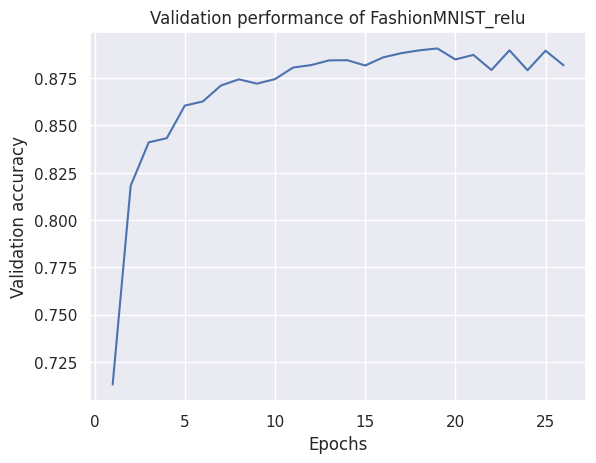

==============Test accuracy: 88.49%===============

Training BaseNetwork with leakyrelu activation...


Epoch 1:   0%|          | 0/195 [00:00<?, ?it/s]

[Epoch  1] Training accuracy: 51.75%, Validation accuracy: 71.52%
	 (new best performance, saving model..)


Epoch 2:   0%|          | 0/195 [00:00<?, ?it/s]

[Epoch  2] Training accuracy: 79.15%, Validation accuracy: 81.84%
	 (new best performance, saving model..)


Epoch 3:   0%|          | 0/195 [00:00<?, ?it/s]

[Epoch  3] Training accuracy: 83.38%, Validation accuracy: 84.03%
	 (new best performance, saving model..)


Epoch 4:   0%|          | 0/195 [00:00<?, ?it/s]

[Epoch  4] Training accuracy: 85.03%, Validation accuracy: 84.46%
	 (new best performance, saving model..)


Epoch 5:   0%|          | 0/195 [00:00<?, ?it/s]

[Epoch  5] Training accuracy: 85.86%, Validation accuracy: 85.84%
	 (new best performance, saving model..)


Epoch 6:   0%|          | 0/195 [00:00<?, ?it/s]

[Epoch  6] Training accuracy: 86.54%, Validation accuracy: 85.92%
	 (new best performance, saving model..)


Epoch 7:   0%|          | 0/195 [00:00<?, ?it/s]

[Epoch  7] Training accuracy: 87.41%, Validation accuracy: 86.73%
	 (new best performance, saving model..)


Epoch 8:   0%|          | 0/195 [00:00<?, ?it/s]

[Epoch  8] Training accuracy: 87.72%, Validation accuracy: 87.17%
	 (new best performance, saving model..)


Epoch 9:   0%|          | 0/195 [00:00<?, ?it/s]

[Epoch  9] Training accuracy: 88.21%, Validation accuracy: 87.30%
	 (new best performance, saving model..)


Epoch 10:   0%|          | 0/195 [00:00<?, ?it/s]

[Epoch 10] Training accuracy: 88.82%, Validation accuracy: 87.22%


Epoch 11:   0%|          | 0/195 [00:00<?, ?it/s]

[Epoch 11] Training accuracy: 89.17%, Validation accuracy: 87.83%
	 (new best performance, saving model..)


Epoch 12:   0%|          | 0/195 [00:00<?, ?it/s]

[Epoch 12] Training accuracy: 89.47%, Validation accuracy: 87.47%


Epoch 13:   0%|          | 0/195 [00:00<?, ?it/s]

[Epoch 13] Training accuracy: 89.61%, Validation accuracy: 88.21%
	 (new best performance, saving model..)


Epoch 14:   0%|          | 0/195 [00:00<?, ?it/s]

[Epoch 14] Training accuracy: 90.31%, Validation accuracy: 88.30%
	 (new best performance, saving model..)


Epoch 15:   0%|          | 0/195 [00:00<?, ?it/s]

[Epoch 15] Training accuracy: 90.58%, Validation accuracy: 88.19%


Epoch 16:   0%|          | 0/195 [00:00<?, ?it/s]

[Epoch 16] Training accuracy: 90.69%, Validation accuracy: 88.03%


Epoch 17:   0%|          | 0/195 [00:00<?, ?it/s]

[Epoch 17] Training accuracy: 91.11%, Validation accuracy: 88.44%
	 (new best performance, saving model..)


Epoch 18:   0%|          | 0/195 [00:00<?, ?it/s]

[Epoch 18] Training accuracy: 91.16%, Validation accuracy: 88.66%
	 (new best performance, saving model..)


Epoch 19:   0%|          | 0/195 [00:00<?, ?it/s]

[Epoch 19] Training accuracy: 91.51%, Validation accuracy: 88.81%
	 (new best performance, saving model..)


Epoch 20:   0%|          | 0/195 [00:00<?, ?it/s]

[Epoch 20] Training accuracy: 91.80%, Validation accuracy: 88.35%


Epoch 21:   0%|          | 0/195 [00:00<?, ?it/s]

[Epoch 21] Training accuracy: 91.81%, Validation accuracy: 88.83%
	 (new best performance, saving model..)


Epoch 22:   0%|          | 0/195 [00:00<?, ?it/s]

[Epoch 22] Training accuracy: 92.04%, Validation accuracy: 88.67%


Epoch 23:   0%|          | 0/195 [00:00<?, ?it/s]

[Epoch 23] Training accuracy: 92.35%, Validation accuracy: 87.94%


Epoch 24:   0%|          | 0/195 [00:00<?, ?it/s]

[Epoch 24] Training accuracy: 92.61%, Validation accuracy: 88.07%


Epoch 25:   0%|          | 0/195 [00:00<?, ?it/s]

[Epoch 25] Training accuracy: 92.84%, Validation accuracy: 88.52%


Epoch 26:   0%|          | 0/195 [00:00<?, ?it/s]

[Epoch 26] Training accuracy: 93.27%, Validation accuracy: 87.85%


Epoch 27:   0%|          | 0/195 [00:00<?, ?it/s]

[Epoch 27] Training accuracy: 93.38%, Validation accuracy: 89.25%
	 (new best performance, saving model..)


Epoch 28:   0%|          | 0/195 [00:00<?, ?it/s]

[Epoch 28] Training accuracy: 93.47%, Validation accuracy: 89.09%


Epoch 29:   0%|          | 0/195 [00:00<?, ?it/s]

[Epoch 29] Training accuracy: 93.51%, Validation accuracy: 88.82%


Epoch 30:   0%|          | 0/195 [00:00<?, ?it/s]

[Epoch 30] Training accuracy: 93.61%, Validation accuracy: 89.03%


Epoch 31:   0%|          | 0/195 [00:00<?, ?it/s]

[Epoch 31] Training accuracy: 94.07%, Validation accuracy: 88.05%


Epoch 32:   0%|          | 0/195 [00:00<?, ?it/s]

[Epoch 32] Training accuracy: 94.22%, Validation accuracy: 88.65%


Epoch 33:   0%|          | 0/195 [00:00<?, ?it/s]

[Epoch 33] Training accuracy: 94.22%, Validation accuracy: 88.04%


Epoch 34:   0%|          | 0/195 [00:00<?, ?it/s]

[Epoch 34] Training accuracy: 94.44%, Validation accuracy: 89.03%
Early stopping due to no improvement over the last 7 epochs


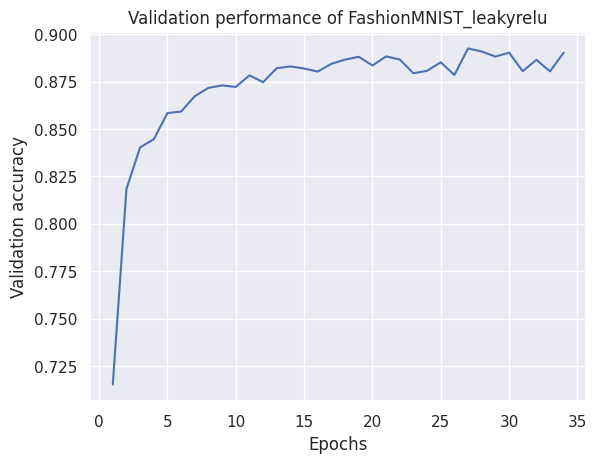

==============Test accuracy: 88.15%===============

Training BaseNetwork with elu activation...


Epoch 1:   0%|          | 0/195 [00:00<?, ?it/s]

[Epoch  1] Training accuracy: 65.94%, Validation accuracy: 78.65%
	 (new best performance, saving model..)


Epoch 2:   0%|          | 0/195 [00:00<?, ?it/s]

[Epoch  2] Training accuracy: 81.62%, Validation accuracy: 82.08%
	 (new best performance, saving model..)


Epoch 3:   0%|          | 0/195 [00:00<?, ?it/s]

[Epoch  3] Training accuracy: 83.92%, Validation accuracy: 84.26%
	 (new best performance, saving model..)


Epoch 4:   0%|          | 0/195 [00:00<?, ?it/s]

[Epoch  4] Training accuracy: 84.82%, Validation accuracy: 84.15%


Epoch 5:   0%|          | 0/195 [00:00<?, ?it/s]

[Epoch  5] Training accuracy: 85.48%, Validation accuracy: 85.15%
	 (new best performance, saving model..)


Epoch 6:   0%|          | 0/195 [00:00<?, ?it/s]

[Epoch  6] Training accuracy: 85.87%, Validation accuracy: 85.15%


Epoch 7:   0%|          | 0/195 [00:00<?, ?it/s]

[Epoch  7] Training accuracy: 86.46%, Validation accuracy: 86.16%
	 (new best performance, saving model..)


Epoch 8:   0%|          | 0/195 [00:00<?, ?it/s]

[Epoch  8] Training accuracy: 86.87%, Validation accuracy: 85.93%


Epoch 9:   0%|          | 0/195 [00:00<?, ?it/s]

[Epoch  9] Training accuracy: 87.20%, Validation accuracy: 86.33%
	 (new best performance, saving model..)


Epoch 10:   0%|          | 0/195 [00:00<?, ?it/s]

[Epoch 10] Training accuracy: 87.50%, Validation accuracy: 85.67%


Epoch 11:   0%|          | 0/195 [00:00<?, ?it/s]

[Epoch 11] Training accuracy: 87.93%, Validation accuracy: 87.02%
	 (new best performance, saving model..)


Epoch 12:   0%|          | 0/195 [00:00<?, ?it/s]

[Epoch 12] Training accuracy: 88.13%, Validation accuracy: 86.81%


Epoch 13:   0%|          | 0/195 [00:00<?, ?it/s]

[Epoch 13] Training accuracy: 88.24%, Validation accuracy: 86.89%


Epoch 14:   0%|          | 0/195 [00:00<?, ?it/s]

[Epoch 14] Training accuracy: 88.57%, Validation accuracy: 87.47%
	 (new best performance, saving model..)


Epoch 15:   0%|          | 0/195 [00:00<?, ?it/s]

[Epoch 15] Training accuracy: 89.02%, Validation accuracy: 87.70%
	 (new best performance, saving model..)


Epoch 16:   0%|          | 0/195 [00:00<?, ?it/s]

[Epoch 16] Training accuracy: 88.84%, Validation accuracy: 87.31%


Epoch 17:   0%|          | 0/195 [00:00<?, ?it/s]

[Epoch 17] Training accuracy: 89.20%, Validation accuracy: 87.55%


Epoch 18:   0%|          | 0/195 [00:00<?, ?it/s]

[Epoch 18] Training accuracy: 89.30%, Validation accuracy: 88.37%
	 (new best performance, saving model..)


Epoch 19:   0%|          | 0/195 [00:00<?, ?it/s]

[Epoch 19] Training accuracy: 89.67%, Validation accuracy: 87.28%


Epoch 20:   0%|          | 0/195 [00:00<?, ?it/s]

[Epoch 20] Training accuracy: 89.76%, Validation accuracy: 87.44%


Epoch 21:   0%|          | 0/195 [00:00<?, ?it/s]

[Epoch 21] Training accuracy: 89.86%, Validation accuracy: 88.19%


Epoch 22:   0%|          | 0/195 [00:00<?, ?it/s]

[Epoch 22] Training accuracy: 89.89%, Validation accuracy: 87.99%


Epoch 23:   0%|          | 0/195 [00:00<?, ?it/s]

[Epoch 23] Training accuracy: 90.25%, Validation accuracy: 88.17%


Epoch 24:   0%|          | 0/195 [00:00<?, ?it/s]

[Epoch 24] Training accuracy: 90.26%, Validation accuracy: 88.14%


Epoch 25:   0%|          | 0/195 [00:00<?, ?it/s]

[Epoch 25] Training accuracy: 90.45%, Validation accuracy: 88.60%
	 (new best performance, saving model..)


Epoch 26:   0%|          | 0/195 [00:00<?, ?it/s]

[Epoch 26] Training accuracy: 90.74%, Validation accuracy: 87.83%


Epoch 27:   0%|          | 0/195 [00:00<?, ?it/s]

[Epoch 27] Training accuracy: 90.80%, Validation accuracy: 88.40%


Epoch 28:   0%|          | 0/195 [00:00<?, ?it/s]

[Epoch 28] Training accuracy: 90.86%, Validation accuracy: 88.48%


Epoch 29:   0%|          | 0/195 [00:00<?, ?it/s]

[Epoch 29] Training accuracy: 91.20%, Validation accuracy: 88.95%
	 (new best performance, saving model..)


Epoch 30:   0%|          | 0/195 [00:00<?, ?it/s]

[Epoch 30] Training accuracy: 91.13%, Validation accuracy: 88.13%


Epoch 31:   0%|          | 0/195 [00:00<?, ?it/s]

[Epoch 31] Training accuracy: 91.25%, Validation accuracy: 88.31%


Epoch 32:   0%|          | 0/195 [00:00<?, ?it/s]

[Epoch 32] Training accuracy: 91.43%, Validation accuracy: 88.74%


Epoch 33:   0%|          | 0/195 [00:00<?, ?it/s]

[Epoch 33] Training accuracy: 91.49%, Validation accuracy: 87.97%


Epoch 34:   0%|          | 0/195 [00:00<?, ?it/s]

[Epoch 34] Training accuracy: 91.67%, Validation accuracy: 88.63%


Epoch 35:   0%|          | 0/195 [00:00<?, ?it/s]

[Epoch 35] Training accuracy: 91.62%, Validation accuracy: 88.75%


Epoch 36:   0%|          | 0/195 [00:00<?, ?it/s]

[Epoch 36] Training accuracy: 91.92%, Validation accuracy: 89.19%
	 (new best performance, saving model..)


Epoch 37:   0%|          | 0/195 [00:00<?, ?it/s]

[Epoch 37] Training accuracy: 92.03%, Validation accuracy: 88.77%


Epoch 38:   0%|          | 0/195 [00:00<?, ?it/s]

[Epoch 38] Training accuracy: 92.38%, Validation accuracy: 88.76%


Epoch 39:   0%|          | 0/195 [00:00<?, ?it/s]

[Epoch 39] Training accuracy: 92.41%, Validation accuracy: 88.90%


Epoch 40:   0%|          | 0/195 [00:00<?, ?it/s]

[Epoch 40] Training accuracy: 92.41%, Validation accuracy: 89.37%
	 (new best performance, saving model..)


Epoch 41:   0%|          | 0/195 [00:00<?, ?it/s]

[Epoch 41] Training accuracy: 92.49%, Validation accuracy: 89.19%


Epoch 42:   0%|          | 0/195 [00:00<?, ?it/s]

[Epoch 42] Training accuracy: 92.60%, Validation accuracy: 88.86%


Epoch 43:   0%|          | 0/195 [00:00<?, ?it/s]

[Epoch 43] Training accuracy: 92.90%, Validation accuracy: 89.04%


Epoch 44:   0%|          | 0/195 [00:00<?, ?it/s]

[Epoch 44] Training accuracy: 93.03%, Validation accuracy: 87.72%


Epoch 45:   0%|          | 0/195 [00:00<?, ?it/s]

[Epoch 45] Training accuracy: 92.94%, Validation accuracy: 89.04%


Epoch 46:   0%|          | 0/195 [00:00<?, ?it/s]

[Epoch 46] Training accuracy: 93.19%, Validation accuracy: 89.03%


Epoch 47:   0%|          | 0/195 [00:00<?, ?it/s]

[Epoch 47] Training accuracy: 93.01%, Validation accuracy: 88.59%
Early stopping due to no improvement over the last 7 epochs


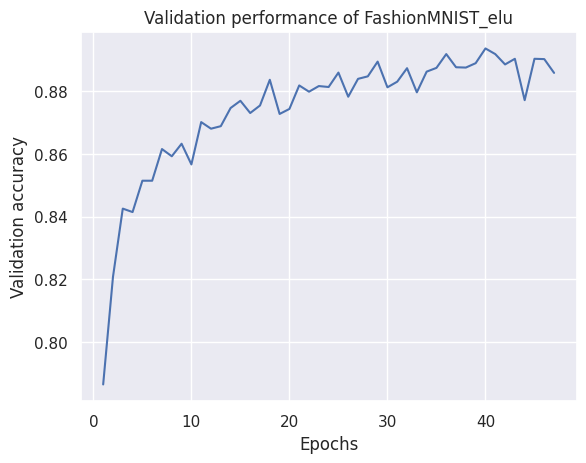

==============Test accuracy: 88.12%===============

Training BaseNetwork with swish activation...


Epoch 1:   0%|          | 0/195 [00:00<?, ?it/s]

[Epoch  1] Training accuracy: 22.85%, Validation accuracy: 47.92%
	 (new best performance, saving model..)


Epoch 2:   0%|          | 0/195 [00:00<?, ?it/s]

[Epoch  2] Training accuracy: 69.23%, Validation accuracy: 77.48%
	 (new best performance, saving model..)


Epoch 3:   0%|          | 0/195 [00:00<?, ?it/s]

[Epoch  3] Training accuracy: 80.09%, Validation accuracy: 81.86%
	 (new best performance, saving model..)


Epoch 4:   0%|          | 0/195 [00:00<?, ?it/s]

[Epoch  4] Training accuracy: 82.89%, Validation accuracy: 82.87%
	 (new best performance, saving model..)


Epoch 5:   0%|          | 0/195 [00:00<?, ?it/s]

[Epoch  5] Training accuracy: 84.02%, Validation accuracy: 84.47%
	 (new best performance, saving model..)


Epoch 6:   0%|          | 0/195 [00:00<?, ?it/s]

[Epoch  6] Training accuracy: 84.69%, Validation accuracy: 84.50%
	 (new best performance, saving model..)


Epoch 7:   0%|          | 0/195 [00:00<?, ?it/s]

[Epoch  7] Training accuracy: 85.51%, Validation accuracy: 85.24%
	 (new best performance, saving model..)


Epoch 8:   0%|          | 0/195 [00:00<?, ?it/s]

[Epoch  8] Training accuracy: 86.09%, Validation accuracy: 85.63%
	 (new best performance, saving model..)


Epoch 9:   0%|          | 0/195 [00:00<?, ?it/s]

[Epoch  9] Training accuracy: 86.39%, Validation accuracy: 85.23%


Epoch 10:   0%|          | 0/195 [00:00<?, ?it/s]

[Epoch 10] Training accuracy: 86.71%, Validation accuracy: 85.30%


Epoch 11:   0%|          | 0/195 [00:00<?, ?it/s]

[Epoch 11] Training accuracy: 87.33%, Validation accuracy: 86.40%
	 (new best performance, saving model..)


Epoch 12:   0%|          | 0/195 [00:00<?, ?it/s]

[Epoch 12] Training accuracy: 87.48%, Validation accuracy: 86.32%


Epoch 13:   0%|          | 0/195 [00:00<?, ?it/s]

[Epoch 13] Training accuracy: 87.74%, Validation accuracy: 86.79%
	 (new best performance, saving model..)


Epoch 14:   0%|          | 0/195 [00:00<?, ?it/s]

[Epoch 14] Training accuracy: 88.03%, Validation accuracy: 87.29%
	 (new best performance, saving model..)


Epoch 15:   0%|          | 0/195 [00:00<?, ?it/s]

[Epoch 15] Training accuracy: 88.43%, Validation accuracy: 87.40%
	 (new best performance, saving model..)


Epoch 16:   0%|          | 0/195 [00:00<?, ?it/s]

[Epoch 16] Training accuracy: 88.30%, Validation accuracy: 86.95%


Epoch 17:   0%|          | 0/195 [00:00<?, ?it/s]

[Epoch 17] Training accuracy: 88.61%, Validation accuracy: 87.64%
	 (new best performance, saving model..)


Epoch 18:   0%|          | 0/195 [00:00<?, ?it/s]

[Epoch 18] Training accuracy: 88.86%, Validation accuracy: 87.92%
	 (new best performance, saving model..)


Epoch 19:   0%|          | 0/195 [00:00<?, ?it/s]

[Epoch 19] Training accuracy: 89.26%, Validation accuracy: 87.20%


Epoch 20:   0%|          | 0/195 [00:00<?, ?it/s]

[Epoch 20] Training accuracy: 89.27%, Validation accuracy: 87.88%


Epoch 21:   0%|          | 0/195 [00:00<?, ?it/s]

[Epoch 21] Training accuracy: 89.47%, Validation accuracy: 88.21%
	 (new best performance, saving model..)


Epoch 22:   0%|          | 0/195 [00:00<?, ?it/s]

[Epoch 22] Training accuracy: 89.50%, Validation accuracy: 87.73%


Epoch 23:   0%|          | 0/195 [00:00<?, ?it/s]

[Epoch 23] Training accuracy: 89.91%, Validation accuracy: 87.97%


Epoch 24:   0%|          | 0/195 [00:00<?, ?it/s]

[Epoch 24] Training accuracy: 89.87%, Validation accuracy: 87.87%


Epoch 25:   0%|          | 0/195 [00:00<?, ?it/s]

[Epoch 25] Training accuracy: 90.05%, Validation accuracy: 88.29%
	 (new best performance, saving model..)


Epoch 26:   0%|          | 0/195 [00:00<?, ?it/s]

[Epoch 26] Training accuracy: 90.32%, Validation accuracy: 87.72%


Epoch 27:   0%|          | 0/195 [00:00<?, ?it/s]

[Epoch 27] Training accuracy: 90.57%, Validation accuracy: 88.21%


Epoch 28:   0%|          | 0/195 [00:00<?, ?it/s]

[Epoch 28] Training accuracy: 90.54%, Validation accuracy: 88.41%
	 (new best performance, saving model..)


Epoch 29:   0%|          | 0/195 [00:00<?, ?it/s]

[Epoch 29] Training accuracy: 90.70%, Validation accuracy: 88.23%


Epoch 30:   0%|          | 0/195 [00:00<?, ?it/s]

[Epoch 30] Training accuracy: 90.94%, Validation accuracy: 87.95%


Epoch 31:   0%|          | 0/195 [00:00<?, ?it/s]

[Epoch 31] Training accuracy: 90.90%, Validation accuracy: 88.25%


Epoch 32:   0%|          | 0/195 [00:00<?, ?it/s]

[Epoch 32] Training accuracy: 91.11%, Validation accuracy: 88.63%
	 (new best performance, saving model..)


Epoch 33:   0%|          | 0/195 [00:00<?, ?it/s]

[Epoch 33] Training accuracy: 91.29%, Validation accuracy: 87.92%


Epoch 34:   0%|          | 0/195 [00:00<?, ?it/s]

[Epoch 34] Training accuracy: 91.41%, Validation accuracy: 88.84%
	 (new best performance, saving model..)


Epoch 35:   0%|          | 0/195 [00:00<?, ?it/s]

[Epoch 35] Training accuracy: 91.52%, Validation accuracy: 88.70%


Epoch 36:   0%|          | 0/195 [00:00<?, ?it/s]

[Epoch 36] Training accuracy: 91.71%, Validation accuracy: 88.99%
	 (new best performance, saving model..)


Epoch 37:   0%|          | 0/195 [00:00<?, ?it/s]

[Epoch 37] Training accuracy: 91.70%, Validation accuracy: 88.77%


Epoch 38:   0%|          | 0/195 [00:00<?, ?it/s]

[Epoch 38] Training accuracy: 92.19%, Validation accuracy: 88.67%


Epoch 39:   0%|          | 0/195 [00:00<?, ?it/s]

[Epoch 39] Training accuracy: 92.17%, Validation accuracy: 88.56%


Epoch 40:   0%|          | 0/195 [00:00<?, ?it/s]

[Epoch 40] Training accuracy: 92.21%, Validation accuracy: 88.93%


Epoch 41:   0%|          | 0/195 [00:00<?, ?it/s]

[Epoch 41] Training accuracy: 92.43%, Validation accuracy: 89.14%
	 (new best performance, saving model..)


Epoch 42:   0%|          | 0/195 [00:00<?, ?it/s]

[Epoch 42] Training accuracy: 92.63%, Validation accuracy: 88.82%


Epoch 43:   0%|          | 0/195 [00:00<?, ?it/s]

[Epoch 43] Training accuracy: 92.80%, Validation accuracy: 88.86%


Epoch 44:   0%|          | 0/195 [00:00<?, ?it/s]

[Epoch 44] Training accuracy: 93.01%, Validation accuracy: 87.92%


Epoch 45:   0%|          | 0/195 [00:00<?, ?it/s]

[Epoch 45] Training accuracy: 92.76%, Validation accuracy: 88.72%


Epoch 46:   0%|          | 0/195 [00:00<?, ?it/s]

[Epoch 46] Training accuracy: 93.15%, Validation accuracy: 89.13%


Epoch 47:   0%|          | 0/195 [00:00<?, ?it/s]

[Epoch 47] Training accuracy: 93.09%, Validation accuracy: 88.64%


Epoch 48:   0%|          | 0/195 [00:00<?, ?it/s]

[Epoch 48] Training accuracy: 93.33%, Validation accuracy: 89.07%
Early stopping due to no improvement over the last 7 epochs


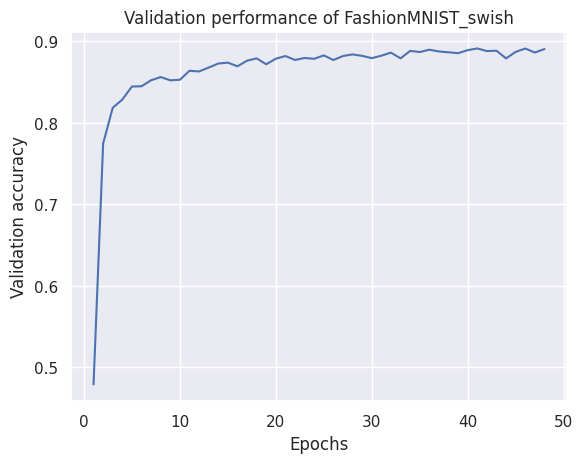

==============Test accuracy: 88.07%===============



In [ ]:
for act_fn_name in act_fn_by_name:
    print(f"Training BaseNetwork with {act_fn_name} activation...")
    act_fn = act_fn_by_name[act_fn_name]()
    net_actfn = BaseNetwork(act_fn=act_fn)
    train_model(net_actfn, f"FashionMNIST_{act_fn_name}", overwrite=False)

In [ ]:
def visualize_activations(net, color="C0"):
    activations = {}

    img, labels = exmp_batch
    _, activations = net(img, return_activations=True)

    columns = 4
    rows = math.ceil(len(activations)/columns)
    fig, ax = plt.subplots(rows, columns, figsize=(columns*2.7, rows*2.5))
    act_fn_name = net.act_fn.__class__.__name__
    for idx, activ in enumerate(activations):
        key_ax = ax[idx//columns][idx%columns]
        sns.histplot(data=activ.reshape(-1), bins=50, ax=key_ax, color=color, kde=True, stat='density')
        key_ax.set_title(f"Layer {idx} - {'Dense' if idx%2==0 else act_fn_name}")
    fig.suptitle(f"Activation distribution for activation function {act_fn_name}", fontsize=14)
    fig.subplots_adjust(hspace=0.4, wspace=0.4)
    plt.show()
    plt.close()


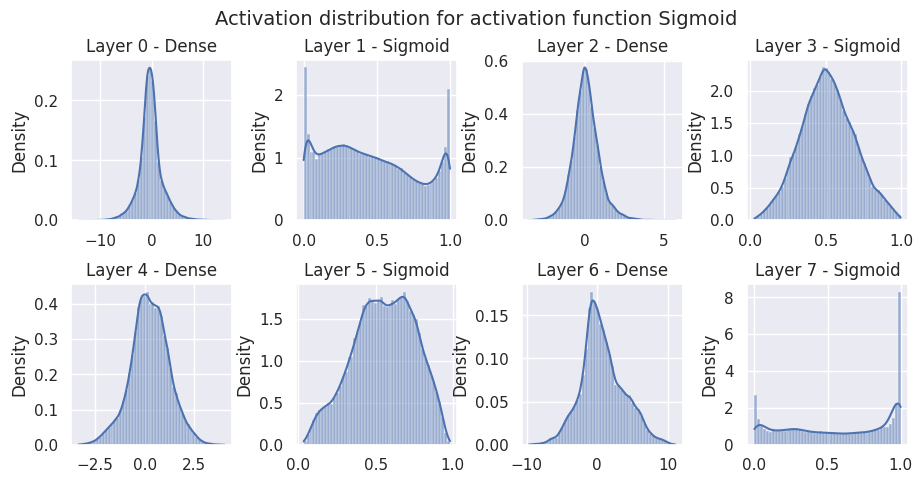

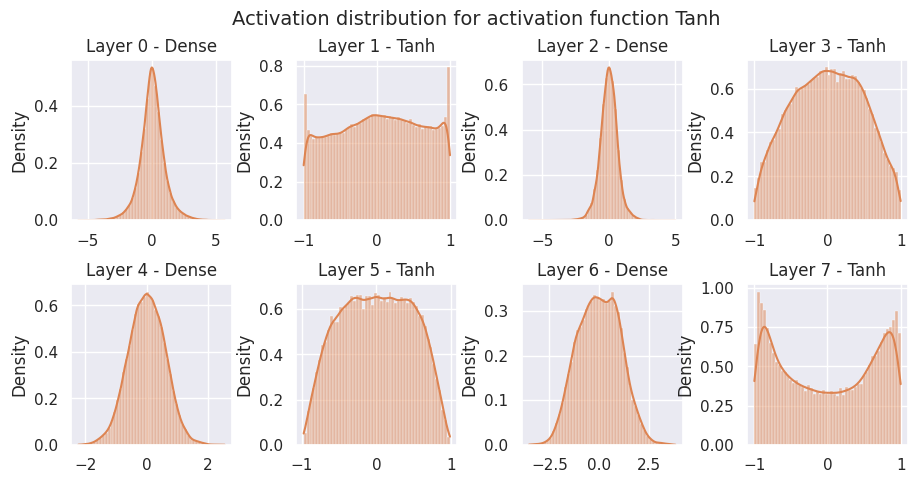

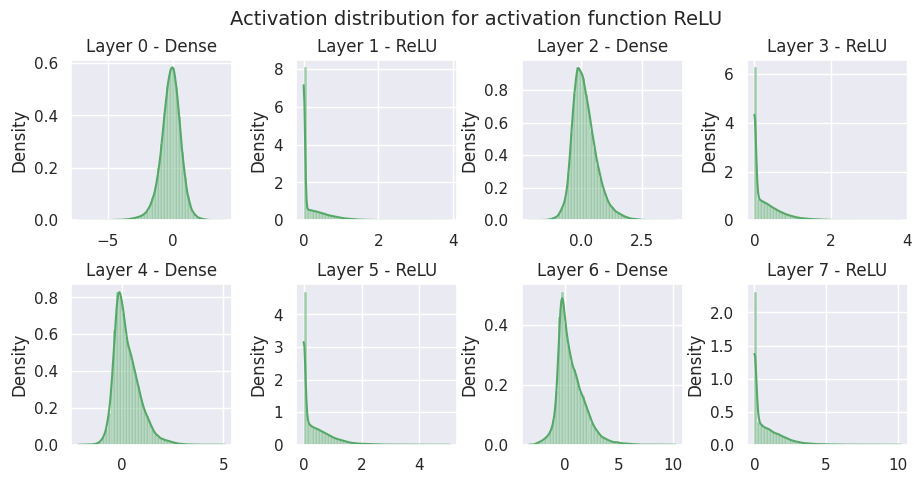

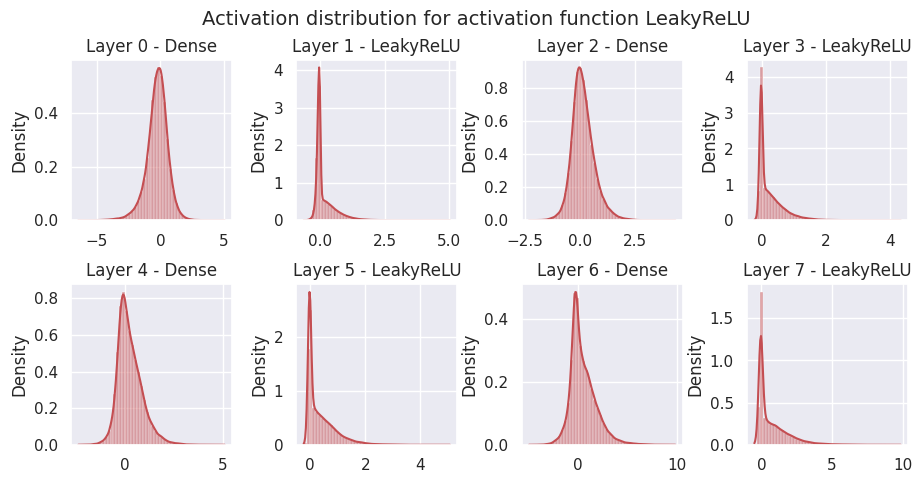

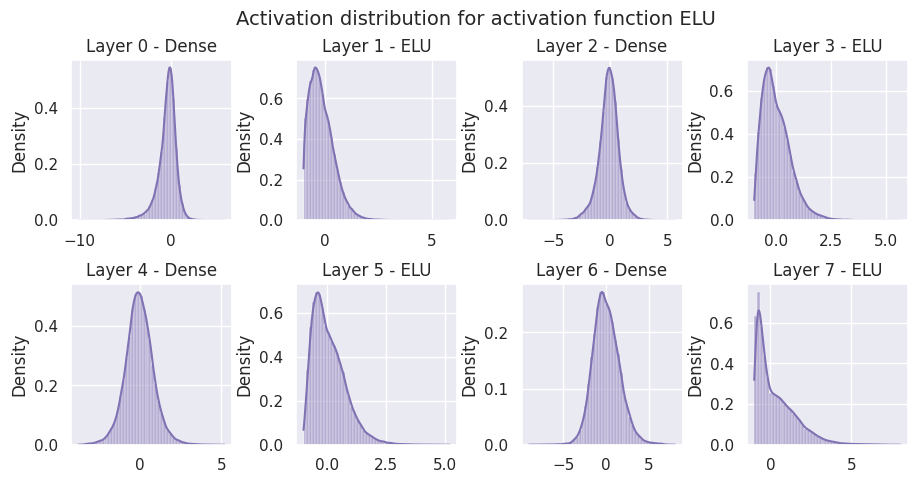

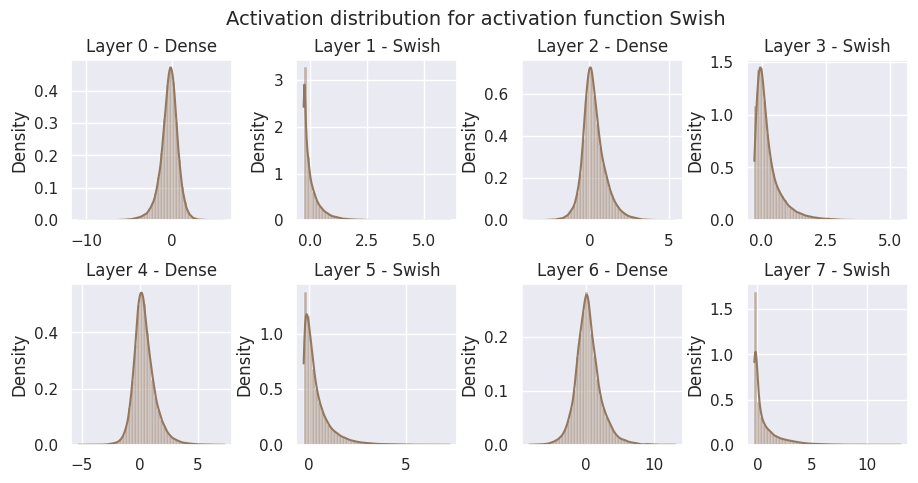

In [ ]:
for i, act_fn_name in enumerate(act_fn_by_name):
    state, net_actfn = load_model(model_path=CHECKPOINT_PATH, model_name=f"FashionMNIST_{act_fn_name}")
    net_actfn = net_actfn.bind(state.params)
    visualize_activations(net_actfn, color=f"C{i}")

In [ ]:
def measure_number_dead_neurons(net, params):
    neurons_dead = [
        jnp.ones(hd, dtype=jnp.dtype('bool')) for hd in net.hidden_sizes
    ]

    get_activations = jax.jit( lambda inp: net.apply(params, inp, return_activations=True)[1])
    for imgs, _ in tqdm(train_loader, leave=False):
        activations = get_activations(imgs)
        for layer_index, activ in enumerate(activations[1::2]):
            neurons_dead[layer_index] = jnp.logical_and(neurons_dead[layer_index],
                                                        (activ == 0).all(axis=0))
    number_neurons_dead = [t.sum().item() for t in neurons_dead]
    print("Number of dead neurons:", number_neurons_dead)
    print("In percentage:", ", ".join([f"{num_dead / tens.shape[0]:4.2%}" for tens, num_dead in zip(neurons_dead, number_neurons_dead)]))


In [ ]:
net_relu = BaseNetwork(act_fn=ReLU())
params = net_relu.init(random.key(42), exmp_batch[0])
measure_number_dead_neurons(net_relu, params)

  0%|          | 0/49 [00:00<?, ?it/s]

Number of dead neurons: [0, 0, 2, 13]
In percentage: 0.00%, 0.00%, 0.78%, 10.16%


In [ ]:
state, net_relu = load_model(model_path=CHECKPOINT_PATH, model_name="FashionMNIST_relu")
measure_number_dead_neurons(net_relu, state.params)

  0%|          | 0/49 [00:00<?, ?it/s]

Number of dead neurons: [0, 0, 2, 4]
In percentage: 0.00%, 0.00%, 0.78%, 3.12%


In [ ]:
net_relu = BaseNetwork(act_fn=ReLU(), hidden_sizes=[256, 256, 256, 256, 256, 128, 128, 128, 128, 128])
params = net_relu.init(random.PRNGKey(42), exmp_batch[0])
measure_number_dead_neurons(net_relu, params)

  0%|          | 0/49 [00:00<?, ?it/s]

Number of dead neurons: [0, 2, 3, 26, 72, 53, 67, 65, 57, 59]
In percentage: 0.00%, 0.78%, 1.17%, 10.16%, 28.12%, 41.41%, 52.34%, 50.78%, 44.53%, 46.09%
